In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import numpy as np
import scanpy as sc
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [3]:
adata = sc.read_10x_h5(
    filename="dataset/filtered_feature_bc_matrix.h5",
    # backup_url="https://figshare.com/ndownloader/files/39546196",
)
adata

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

# Filtering low quality reads

In [5]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

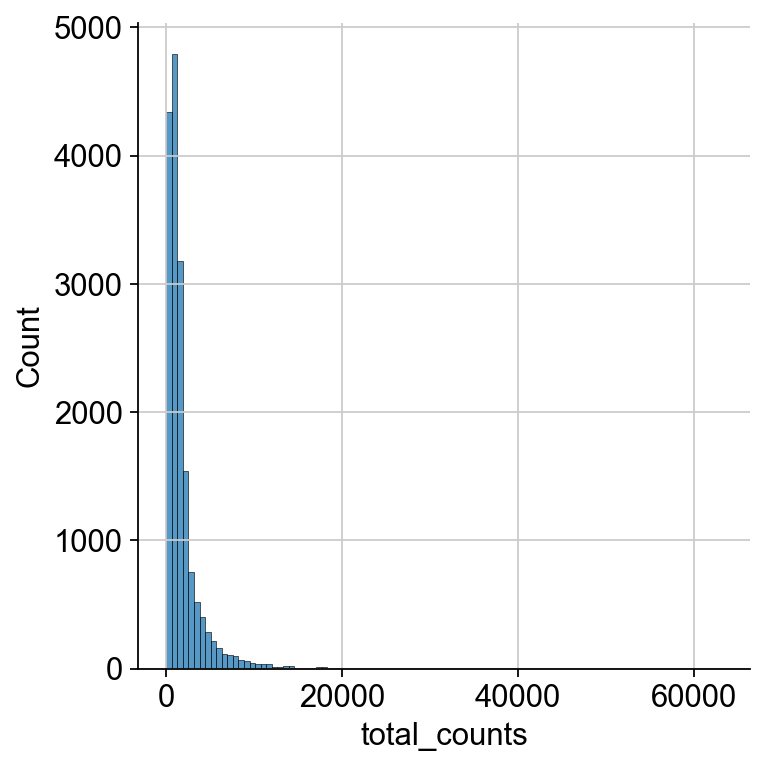

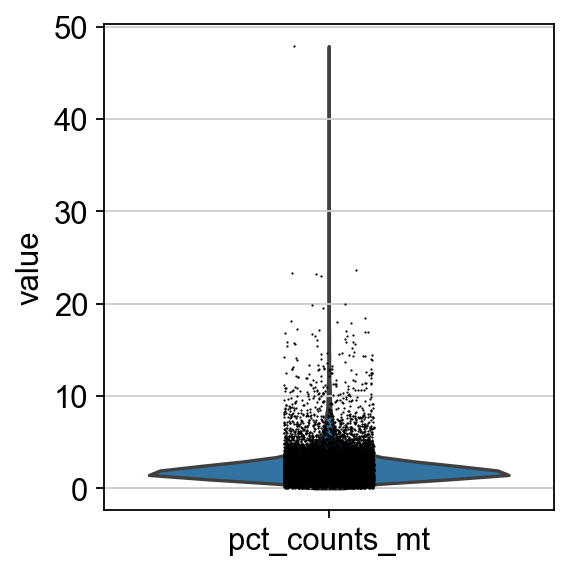

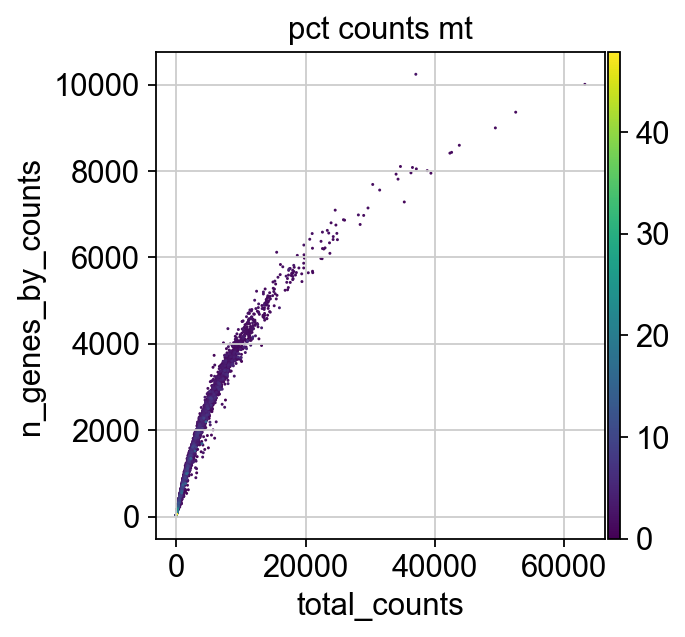

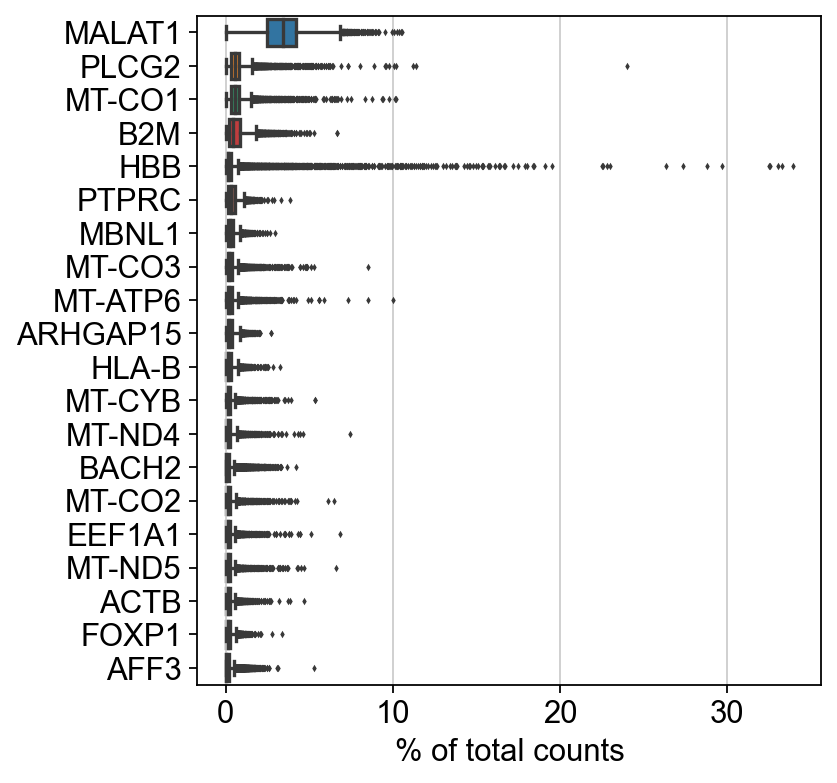

In [7]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.highest_expr_genes(adata, n_top=20)

In [7]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    # median absolute deviation
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [8]:
# outlier detection, 5 median absolute deviations

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    16065
True       869
Name: outlier, dtype: int64

In [9]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

False    15240
True      1694
Name: mt_outlier, dtype: int64

In [10]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 16934
Number of cells after filtering of low quality cells: 14814


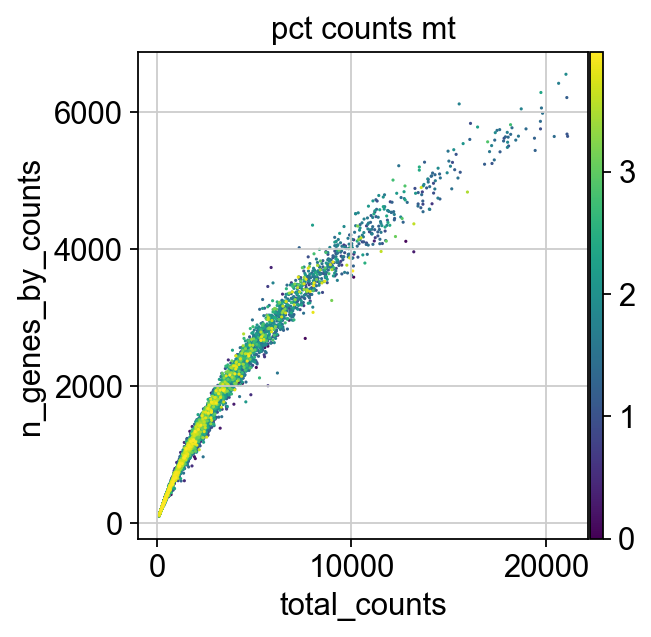

In [11]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# Correction of ambient RNA

In [12]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_1272456/3659631106.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [13]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)
rgeos version: 0.6-4, (SVN revision 699)
 GEOS runtime version: 3.12.0-CAPI-1.18.0 
 Please note that rgeos will be retired during October 2023,
plan transition to sf or terra functions using GEOS at your earliest convenience.
See https://r-spatial.org/r/2023/05/15/evolution4.html for details.
 GEOS using OverlayNG
 Linking to sp version: 2.0-0 
 Polygon checking: TRUE 



In [14]:
# SoupX can be run without clustering information, however the results are better if a basic clustering is provided. 

adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

In [15]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]
del adata_pp

In [16]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [18]:
# SoupX additionally required the raw gene by cells matrix
adata_raw = sc.read_10x_h5(
    filename="dataset/raw_feature_bc_matrix.h5",
    # backup_url="https://figshare.com/ndownloader/files/39546217",
)
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [19]:
del adata_raw

 The inputs:
 - filtered cellranger matrix of shape barcodes x cells
 - the raw table of droplets from cellranger of shape barcodes x droplets
 - the gene and cell names
 - the clusters obtained by simple leiden clustering. 
 
The output:
 - the corrected count matrix.

In [20]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

408 genes passed tf-idf cut-off and 203 soup quantile filter.  Taking the top 100.
Using 451 independent estimates of rho.
Estimated global rho of 0.06
Expanding counts from 15 clusters to 14814 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


In [21]:
# In all following analysis steps, we would like to use the SoupX corrected count matrix

adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

In [22]:
adata

AnnData object with n_obs × n_vars = 14814 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts', 'soupX_counts'

In [23]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 20200


# Doublet Detection

In [24]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

Attaching SeuratObject
Attaching sp
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMe

In [25]:
data_mat = adata.X.T

In [26]:
%%R -i data_mat -o doublet_score -o doublet_class

# launch the doublet detection by using data_mat as input to scDblFinder within a SingleCellExperiment object.

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score  #  the final doublet score (the higher the more likely that the cell is a doublet)
doublet_class = sce$scDblFinder.class  # the classification (doublet or singlet)

dimnames(.) <- NULL translated to
dimnames(.) <- list(NULL,NULL)
dimnames(.) <- NULL translated to
dimnames(.) <- list(NULL,NULL)
dimnames(.) <- NULL translated to
dimnames(.) <- list(NULL,NULL)
Creating ~11852 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 3571 cells excluded from training.
iter=1, 3845 cells excluded from training.
iter=2, 3742 cells excluded from training.
Threshold found:0.546
3004 (20.3%) doublets called
In addition: Warning message:
In .checkSCE(sce) :
  Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out


In [27]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    11810
doublet     3004
Name: scDblFinder_class, dtype: int64

In [ ]:
# adata.write("s4d8_quality_control.h5ad")